In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


In [511]:
data = pd.read_excel("./processed_quant_mid.xlsx", sheet_name=None)

# 각 Sheet별 데이터 프레임 생성
stock_df = data['Sheet1'].set_index('Date')
four_factors_df = data['Sheet2'].set_index('Date')


#  상장폐지 수익률 -100% 처리를 위한 데이터 전처리
#  stock 과 4팩터 데이터의 각 열의 마지막 유효값 인덱스 확인 및 마지막 유효값 다음 값은 0으로 처리

last_valid_index_stock = stock_df.apply(lambda col: col.last_valid_index())
last_valid_index_market = four_factors_df.apply(lambda col: col.last_valid_index())

for column in stock_df.columns:
    last_valid_date = stock_df[column].last_valid_index()
    next_row_index = stock_df.index.get_loc(last_valid_date) + 1 if last_valid_date is not None else None
    if next_row_index is not None and next_row_index < len(stock_df):
        stock_df.at[stock_df.index[next_row_index], column] = 0

for column in four_factors_df.columns:
    last_valid_date = four_factors_df[column].last_valid_index()
    next_row_index = four_factors_df.index.get_loc(last_valid_date) + 1 if last_valid_date is not None else None
    if next_row_index is not None and next_row_index < len(four_factors_df):
        four_factors_df.at[four_factors_df.index[next_row_index], column] = 0


# 월별 수익률 계산
stock_returns = stock_df.pct_change()
four_factors_returns = four_factors_df.pct_change()


/var/folders/dd/cw0ctdzd5zg5s2r6dn4104fr0000gn/T/ipykernel_93518/2569607582.py:28: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = stock_df.pct_change()


In [524]:
# # 과거 N 개월 데이터를 사용하여 롤링 윈도우 방식으로 베타 구하기 1번 코드
rolling_window = 12

betas = pd.DataFrame(index=stock_returns.index, columns=stock_returns.columns)
for column in stock_returns.columns:
    for i in range(len(stock_returns) - rolling_window + 1):
        # 롤링 윈도우 내의 종목 수익률, 시장 수익률 데이터 가져오기
        stock_window = stock_returns[column].iloc[i:i+rolling_window]
        market_window = four_factors_returns['I.001'].iloc[i:i+rolling_window]
        
        # 롤링 윈도우내에서 주식 및 시장 수익률 간의 공분산 및 베타 계산
        covariance = stock_window.cov(market_window)
        market_variance = market_window.var()
        beta = covariance / market_variance
        # 종목별 베타 계산값 저장
        betas.at[stock_returns.index[i+rolling_window-1], column] = beta


/opt/anaconda3/envs/anaconda_kaist/lib/python3.11/site-packages/pandas/core/nanops.py:1675: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b, ddof=ddof)[0, 1]
/opt/anaconda3/envs/anaconda_kaist/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/anaconda_kaist/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [523]:
# # # 과거 N 개월 데이터를 사용하여 롤링 윈도우 방식으로 베타 구하기 2번 코드
# N = 12

# market_mean_N_month = four_factors_returns['I.001'].rolling(window=N).mean()
# market_var_N_month = four_factors_returns['I.001'].rolling(window=N).var()
# stock_returns_N_month = stock_returns.rolling(window=N).mean()

# def calculate_beta(stock_returns, market_returns, market_mean_N_month, market_var_N_month):
#     covariance = (stock_returns - stock_returns.rolling(window=N).mean()) * (market_returns - market_mean_N_month)
#     # covariance = (stock_returns - stock_returns.rolling(window=N).mean()) * (market_returns - market_mean_N_month)
#     beta = covariance / market_var_N_month
#     return beta

# betas = stock_returns.apply(lambda x: calculate_beta(x, four_factors_returns['I.001'], market_mean_N_month, market_var_N_month))



A005930    0.983158
A000660    0.937403
A373220    1.326650
A207940    1.156735
A005380    0.975272
             ...   
A950010    1.582260
A950030    0.335504
A950070   -1.393228
A950100   -1.613806
A950180    2.410375
Length: 3684, dtype: float64

In [514]:
# 각 행별 베타값을 기준으로 10분위로 나누기
decile_returns = pd.DataFrame(index=stock_returns.index, columns=[f"D{i+1}" for i in range(10)])

# def assign_beta_decile_levels(betas):
#     if betas.isna().all():  # If all values are NaN, return the same
#         return betas
#     labels = [f"D{i+1}" for i in range(10)]
#     return pd.qcut(betas.dropna(), 10, labels=labels, duplicates='drop')
# # Assign decile labels to each beta value row-wise with check for non-NaN values
# deciles = betas.apply(assign_beta_decile_levels, axis=1)

def assign_beta_decile_levels(betas):
    if betas.isna().all():  # 모든 값이 NaN인 경우, 변경 없이 반환합니다.
        return betas
    # 음수인 베타값을 제외하고 나머지 값에 대해 분위수를 할당합니다.
    betas_non_negative = betas.dropna()[betas.dropna() >= 0]
    if betas_non_negative.empty:
        return pd.Series(index=betas.index)  # 모든 값이 음수인 경우, 빈 Series를 반환합니다.
    labels = [f"D{i+1}" for i in range(10)]
    return pd.qcut(betas_non_negative, 10, labels=labels, duplicates='drop')

deciles = betas.apply(assign_beta_decile_levels, axis=1)


In [515]:
# 베타 각 분위수별로 평균 수익률 구하기
for date, row in deciles.iterrows():
    for decile in decile_returns.columns:
        selected_stocks = row[row == decile].index
        if not selected_stocks.empty:
            decile_returns.at[date, decile] = stock_returns.loc[date, selected_stocks].mean()
decile_returns = decile_returns.astype(float)


In [516]:
# 저베타 전략을 4팩터에 대한 회기 분석 후 베타분위수별 알파 구하기
factors = four_factors_returns[['I.001', '3FM.2B3.SMB', '3FM.2B3.HML', '3FM.2M3.MOM']].astype(float)
factors = sm.add_constant(factors)

# 베타 분위수별 회귀 분석 수행을 위한 함수 선언
def regress_and_get_alpha(returns, factors):
    model = sm.OLS(returns, factors, missing='drop').fit()
    return model.params[0]  # alpha is the intercept

# 베타 분위수별 회귀 분석 수행 후 알파 저장
decile_alphas = {}
for decile in decile_returns.columns:
    decile_alphas[decile] = regress_and_get_alpha(decile_returns[decile], factors)

decile_alphas_df = pd.DataFrame(list(decile_alphas.items()), columns=['Decile', 'Alpha'])


/var/folders/dd/cw0ctdzd5zg5s2r6dn4104fr0000gn/T/ipykernel_93518/3168716651.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[0]  # alpha is the intercept


Text(0.5, 1.0, 'Beta decile alpha')

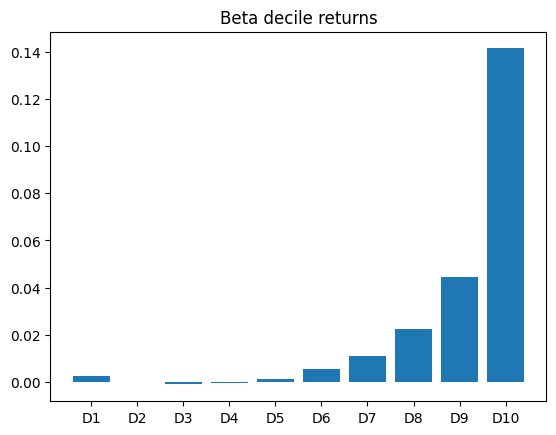

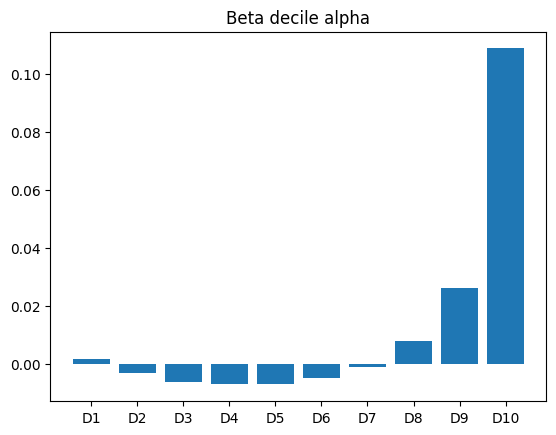

In [517]:


# # 분위수별 평균 수익률 차트 표현

plt.figure(1)
plt.bar(decile_returns.mean().index,decile_returns.mean().values)
plt.title('Beta decile returns')

# 분위수별 알파 차트 표현
plt.figure(2)
plt.bar(decile_alphas_df['Decile'], decile_alphas_df['Alpha'])
plt.title("Beta decile alpha")


In [525]:
#BAB 전략 구현 수식
z_i = betas.rank(axis=1)
z_bar = z_i.mean(axis=1)

deviations = z_i.subtract(z_bar, axis=0)
deviations

k = 2 / deviations.abs().sum(axis=1)

positive_deviations = deviations.clip(lower=0)
negative_deviations = deviations.clip(upper=0).abs()

w_H = positive_deviations.multiply(k, axis=0)
w_L = negative_deviations.multiply(k, axis=0)

# 무위험 이자율 0으로 설정
r_f = 0

# BAB 전략에 따른 levered, delevered weight
beta_L = (betas * w_L).sum(axis=1) / np.where(w_L.sum(axis=1) != 0, w_L.sum(axis=1), np.nan)
beta_H = (betas * w_H).sum(axis=1) / np.where(w_H.sum(axis=1) != 0, w_H.sum(axis=1), np.nan)
# beta_L = (betas * w_L).sum(axis=1) / w_L.sum(axis=1)
# beta_H = (betas * w_H).sum(axis=1) / w_H.sum(axis=1)
beta_data = pd.DataFrame({'beta_L': beta_L, 'beta_H': beta_H})


# BAB Return
return_L = (stock_returns.shift(-1) * w_L).sum(axis=1) / w_L.sum(axis=1) 
return_H = (stock_returns.shift(-1) * w_H).sum(axis=1) / w_H.sum(axis=1)
BAB_returns = (return_L - r_f) / beta_L - (return_H - r_f) / beta_H



In [536]:
cumulative_log_returns = np.log1p(BAB_returns).cumsum()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log1p method

In [537]:
#4팩터 회귀 분석 
four_factors = four_factors_returns[['I.001', '3FM.2B3.SMB', '3FM.2B3.HML', '3FM.2M3.MOM']].astype(float)

four_factors_with_constant = sm.add_constant(four_factors)

BAB_regression_model = sm.OLS(BAB_returns, four_factors_with_constant, missing='drop').fit()

BAB_regression_model.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

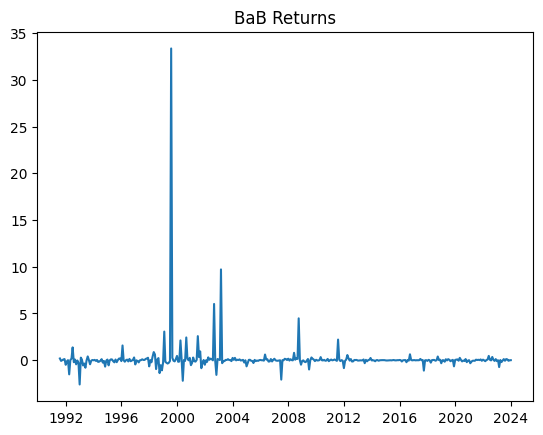

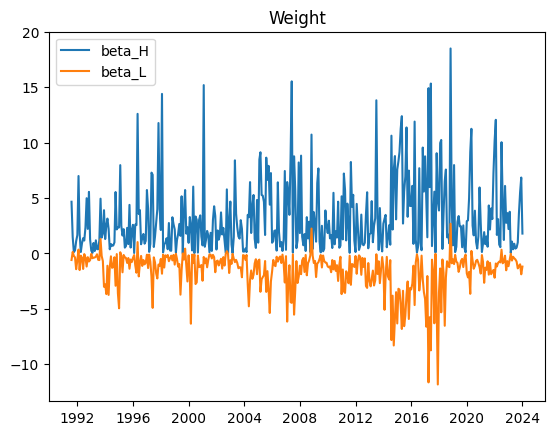

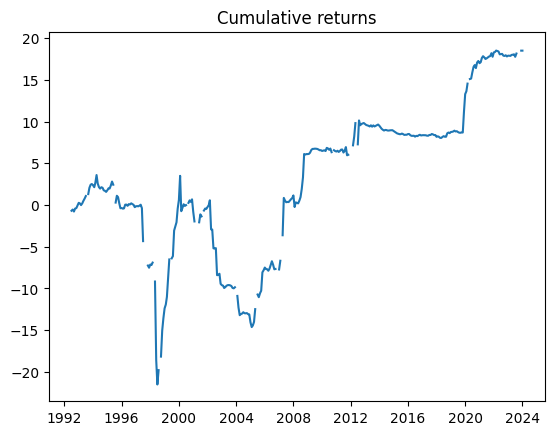

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8853
Date:                Sun, 21 Apr 2024   Prob (F-statistic):              0.473
Time:                        17:53:11   Log-Likelihood:                -791.91
No. Observations:                 390   AIC:                             1594.
Df Residuals:                     385   BIC:                             1614.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1441      0.096      1.501      

In [520]:
plt.figure(3)
plt.title('BaB Returns')
plt.plot(BAB_returns.index, BAB_returns.values)

# beta_L과 beta_H 비중 차트 표현
plt.figure(4)
plt.title('Weight')
plt.plot(beta_data.index, beta_data['beta_H'])
plt.plot(beta_data.index, beta_data['beta_L']) 
plt.legend(["beta_H", "beta_L"])

# BAB 팩터의 로그 누적 수익률
plt.figure(5)
plt.title('Cumulative returns')
plt.plot(cumulative_log_returns.index, cumulative_log_returns.values)

plt.show()
#4팩터 회귀 분석 결과 출력
print(BAB_regression_model.summary())